In [1]:
import datetime
from statistics import stdev
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, precision_recall_curve,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
hr = pd.read_csv("data.csv")

In [3]:
def explore(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

In [4]:
explore(hr)

,data type,percent missing,No. unique,unique values
Age,int64,0.0,43,"[41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2..."
YearsInCurrentRole,int64,0.0,19,"[4, 7, 0, 2, 5, 9, 8, 3, 6, 13, 1, 15, 14, 16,..."
YearsAtCompany,int64,0.0,37,"[6, 10, 0, 8, 2, 7, 1, 9, 5, 4, 25, 3, 12, 14,..."
WorkLifeBalance,int64,0.0,4,"[1, 3, 2, 4]"
TrainingTimesLastYear,int64,0.0,7,"[0, 3, 2, 5, 1, 4, 6]"
TotalWorkingYears,int64,0.0,40,"[8, 10, 7, 6, 12, 1, 17, 5, 3, 31, 13, 0, 26, ..."
StockOptionLevel,int64,0.0,4,"[0, 1, 3, 2]"
StandardHours,int64,0.0,1,[80]
RelationshipSatisfaction,int64,0.0,4,"[1, 4, 2, 3]"
PerformanceRating,int64,0.0,2,"[3, 4]"


In [5]:

hr = hr.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1)

In [7]:
attrition_yes = hr[hr['Attrition'] == 'Yes']
attrition_gender_counts = attrition_yes['Gender'].value_counts()

fig = px.pie(values=attrition_gender_counts, names=attrition_gender_counts.index, 
             title='<b>Attrition by Gender</b>',
             labels={'names': 'Gender', 'values': 'Count'}, height=400,                     
             color_discrete_sequence=['#C53E4A', '#419D9D'])  # Specify colors directly here

fig.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7',
                  plot_bgcolor='#EADFC7')

fig.show()

The data indicates that the attrition rate is 36.7% for females and 63.3% for males. This suggests a higher attrition rate among males compared to females, potentially influenced by various factors such as job satisfaction, career opportunities, and workplace environment.

### relationship between attrition and age?

In [8]:
# Grouping by age and attrition status, counting daily rates, and resetting index

age_att = hr.groupby(['Age','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')

line_chart = px.line(age_att, x='Age', y='Counts', color='Attrition',
                     title='<b>Age Distribution within Organization with Attriton</b>', height=500,
                     color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})  # Specify line colors here

line_chart.update_traces(texttemplate='%{text:.2f}%', 
                  textposition='top center',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

line_chart.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7',
                  plot_bgcolor='#EADFC7')


line_chart.show()


The age group between 28-32 witnesses the highest attrition rate, indicating a critical phase where individuals may reassess their career paths. This trend gradually declines with advancing age, reflecting a growing emphasis on job stability and long-term commitments.
Conversely, the early career stages, notably between 18-20, often see heightened attrition as individuals explore different opportunities. This pattern reaches a turning point around the age of 21, marking a transition towards more stable employment decisions.

## Exploring the Influence of Income of Employee Atrrition Rates

In [9]:
# Grouping by monthly income and attrition status, counting occurrences, and resetting index
rate_att = hr.groupby(['MonthlyIncome', 'Attrition']).size().reset_index(name='Counts')

# Rounding monthly income to the nearest thousand
rate_att['MonthlyIncome'] = round(rate_att['MonthlyIncome'], -3)

# Grouping again by rounded monthly income and attrition status, counting occurrences, and resetting index
rate_att = rate_att.groupby(['MonthlyIncome', 'Attrition']).size().reset_index(name='Counts')

# Creating the line chart
line_chart = px.line(rate_att, x='MonthlyIncome', y='Counts', color='Attrition',
                     title='<b>Monthly Income-based Counts of People in an Organization</b>', height=500,
                     color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})  # Specify line colors here

line_chart.update_traces(texttemplate='%{text:.2f}%', 
                  textposition='top center',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

line_chart.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.5),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7', 
                  plot_bgcolor='#EADFC7')
line_chart.show()


Examining the above chart reveals a significant increase in attrition rates at very low income levels, specifically below 5000 per month. This trend gradually decreases, with a slight increase observed around the 10000 mark, indicative of the middle-class livelihood.
Individuals in this income bracket often aspire to enhance their standards of living, leading them to seek new job opportunities. Conversely, as monthly income reaches a more comfortable level, the likelihood of employee turnover diminishes, as evidenced by the stable, flat line.

### Impact of Job Satisfaction on Employee Attrition with Average Monthly Salary

In [10]:
# Map job satisfaction level to corresponding text labels
job_satisfaction_labels = {
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very High'
}

# Convert 'JobSatisfaction' column to text labels
hr['JobSatisfaction'] = hr['JobSatisfaction'].map(job_satisfaction_labels)

# Group data by 'JobSatisfaction' and 'Attrition', calculate average monthly income
avg_inc = hr.groupby(['JobSatisfaction', 'Attrition'])['MonthlyIncome'].mean().reset_index()

# Create Plotly plot
fig = px.bar(avg_inc, x='JobSatisfaction', y='MonthlyIncome', color='Attrition', barmode='group',
             title='<b>Average Income and Job Satisfaction by Attrition Status</b>',
             labels={'JobSatisfaction': 'Level of Job Satisfaction', 'MonthlyIncome': 'Average Monthly Income'},
             category_orders={'JobSatisfaction': sorted(hr['JobSatisfaction'].unique())}, height=500,
            color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})  # Specify custom colors

# Add data labels with adjusted positions
for trace in fig.data:
    if trace.name == 'Yes':
        for i, label in enumerate(trace.y):
            fig.add_annotation(x=trace.x[i], y=label, text=str(round(label, 2)),
                               showarrow=False, font=dict(color='black', size=12), yshift=10, xshift=45)
    else:
        for i, label in enumerate(trace.y):
            fig.add_annotation(x=trace.x[i], y=label, text=str(round(label, 2)),
                               showarrow=False, font=dict(color='black', size=12), yshift=10, xshift=-45)

# Add percentage labels to the bars
fig.update_traces(textposition='outside',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

fig.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.49),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7', 
                  plot_bgcolor='#EADFC7')

fig.show()

In analyzing attrition trends, it's evident that individuals with lower levels of job satisfaction are more inclined to leave their positions. This trend is particularly noticeable among those earning an average monthly salary of $4596, indicating that dissatisfaction may drive employee turnover.

Conversely, individuals with higher satisfaction levels, especially those earning an average monthly salary of $6853, are more likely to remain with the company. This suggests that job satisfaction plays a crucial role in employee retention, with higher satisfaction levels mitigating the risk of attrition.

Overall, this insight underscores the importance of fostering a positive work environment and addressing factors contributing to job dissatisfaction to reduce attrition rates and retain valuable talent within the organization.

### Analysis of Attrition Rates Across Departments

In [11]:
# Group data by Department and Attrition, count occurrences, and reset index
dept_att = hr.groupby(['Department', 'Attrition']).size().reset_index(name='Counts')

# Calculate total counts per department
dept_total_counts = dept_att.groupby('Department')['Counts'].transform('sum')

# Calculate percentage within each department
dept_att['Percentage'] = (dept_att['Counts'] / dept_total_counts) * 100

# Create a bar plot
fig = px.bar(dept_att, x='Department', y='Counts', color='Attrition',
             title='<b>Department-wise Distribution of Employees by Attrition Status</b>',
             text='Percentage', # Use 'Percentage' column as text
             labels={'Counts': 'Count', 'Percentage': 'Percentage'}, height = 500, 
            color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})  # Specify custom colors

# Add percentage labels to the bars
fig.update_traces(texttemplate='%{text:.2f}%', 
                  textposition='outside',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

fig.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.49),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7', 
                  plot_bgcolor='#EADFC7')

fig.show()


This dataset includes three primary departments. Among them, the Sales department exhibits the highest attrition rate at 20.63%, trailed by the Human Resources Department at 19.05%. Conversely, the Research and Development department demonstrates the lowest attrition rate, indicating stability and contentment within the department, as depicted in the chart (13.84%).

### Attrition Rates Across Job Roles: A Hierarchy of Stability

In [12]:
# Group data by JobRole and Attrition, calculate count and percentage
attr_job = hr.groupby(['JobRole', 'Attrition']).size().unstack(fill_value=0)
attr_job['Total'] = attr_job.sum(axis=1)
attr_job['Attrition_Rate'] = attr_job['Yes'] / attr_job['Total'] * 100

attr_job = attr_job.sort_values('Attrition_Rate')

fig = go.Figure()

# Add 'Yes' Attrition bars
fig.add_trace(go.Bar(y=attr_job.index,
                     x=attr_job['Attrition_Rate'],
                     name='Attrition: Yes',
                     orientation='h',
                     marker_color='#C53E4A'))

# Add 'No' Attrition bars
fig.add_trace(go.Bar(y=attr_job.index,
                     x=100 - attr_job['Attrition_Rate'],
                     name='Attrition: No',
                     orientation='h',
                     marker_color='#419D9D'))

fig.update_layout(
    title='<b>Attrition by Job Role</b>',
    title_x=0.5,
    xaxis_title='Attrition Rate (%)',
    yaxis_title='Job Role',
    barmode='relative',
    bargap=0.1,
    legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center',  x=0.50),
    height=500,
    font_color='#28221D', 
    paper_bgcolor='#EADFC7',
    plot_bgcolor='#EADFC7'
)

fig.show()

The analysis suggests that higher-level job roles within the organization demonstrate lower attrition rates compared to lower-level roles. Positions such as manufacturing directors, healthcare representatives, managers, and research directors exhibit notably lower attrition rates, indicating that individuals in these roles are less likely to leave the company.

Conversely, roles at lower organizational levels, such as sales representatives, laboratory technicians, and human resources personnel, demonstrate higher attrition rates. This insight implies that individuals in higher-level job roles tend to stay with the company more consistently, contributing to a more stable workforce

### The Impact of Salary Hikes on Employee Retention

In [13]:
hike_att = hr.groupby(['PercentSalaryHike', 'Attrition']).apply(lambda x: x['DailyRate'].count()).reset_index(name='Counts')

line_plot = px.line(hike_att, x='PercentSalaryHike', y='Counts', color='Attrition',
                    title='<b>Distribution of Salary Hike Percentages Among Employees</b>', height=500,
                    color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})

line_plot.update_traces(texttemplate='%{text:.2f}%', 
                  textposition='top center',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

line_plot.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.5),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7', 
                  plot_bgcolor='#EADFC7')

line_plot.show()

Enhanced salary increments serve as a significant incentive for employees, encouraging improved performance and fostering retention within the organization. Consequently, the likelihood of an employee departing from an organization offering lower salary hikes is considerably higher compared to one providing substantial salary increments.

### Examining Work experience diversity among employees

In [14]:
exp_att = hr.groupby(['NumCompaniesWorked', 'Attrition']).size().reset_index(name='Counts')

area_plot = px.area(exp_att, x='NumCompaniesWorked', y='Counts', color='Attrition',
                    title='<b>Distribution of Work Experience Levels Among Employees</b>', line_shape='spline', height=500,
                    color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})

area_plot.update_traces(texttemplate='%{text:.2f}%', 
                  textposition='top center',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

area_plot.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.4, xanchor='center', x=0.5),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7', 
                  plot_bgcolor='#EADFC7')

area_plot.update_layout(title_x=0.5, legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.5))

area_plot.show()

The chart illustrates a notable trend: individuals who begin their careers with the company or transition to it early on are more likely to seek opportunities elsewhere. Conversely, those with extensive experience across multiple companies tend to exhibit greater loyalty to their current employer.

### Effect of Salary Hikes on Employee Retention and Motivation

In [42]:
promotion_att = hr.groupby(['PercentSalaryHike', 'Attrition']).apply(lambda x: x['DailyRate'].count()).reset_index(name='Counts')

fig = px.line(promotion_att, x='PercentSalaryHike', y='Counts', color='Attrition', 
              title='<b>Percent Salary Hike of Employees in the Organization</b>', height=500, 
              color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})  # Specify line colors here

fig.update_traces(texttemplate='%{text:.2f}%', 
                  textposition='top center',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

fig.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.5),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7', 
                  plot_bgcolor='#EADFC7')

fig.show()


Increased salary raises inspire individuals to perform more effectively and remain committed to the organization. Consequently, we observe that the likelihood of an employee departing from a company with lower salary increments is significantly higher compared to one that offers substantial raises.

### Attrition Rates Across Education Levels

In [16]:
import plotly.express as px

education_labels = {
    1: 'Below College',
    2: 'College',
    3: 'Bachelor',
    4: 'Master',
    5: 'Doctor'
}

# Group data by Education and Attrition, count occurrences, and reset index
dept_att = hr.groupby(['Education', 'Attrition']).size().reset_index(name='Counts')

# Calculate total counts per Education
dept_total_counts = dept_att.groupby('Education')['Counts'].transform('sum')

# Calculate percentage within each Education
dept_att['Percentage'] = (dept_att['Counts'] / dept_total_counts) * 100

# Replace education codes with labels
dept_att['Education'] = dept_att['Education'].map(education_labels)

# Create a bar plot
fig = px.bar(dept_att, x='Education', y='Counts', color='Attrition',
             title='<b>Education-wise Distribution of Employees by Attrition Status</b>',
             text='Percentage', # Use 'Percentage' column as text
             labels={'Counts': 'Count', 'Percentage': 'Percentage'}, height=550, # Update axis labels
             color_discrete_map={'Yes': '#C53E4A', 'No': '#419D9D'})  # Specify custom colors

# Add percentage labels to the bars
fig.update_traces(texttemplate='%{text:.2f}%', 
                  textposition='outside',
                  textfont_size=14, 
                  textfont_color='black',
                  marker=dict(line=dict(color='#28221D', width=1)))

fig.update_layout(title_x=0.5, 
                  legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.49),
                  font_color='#28221D',
                  paper_bgcolor='#EADFC7', 
                  plot_bgcolor='#EADFC7')

fig.show()


The graph indicates that individuals with education levels below college have the highest attrition rate at 18.24%. This may be because they face limited opportunities for career advancement or feel dissatisfied with roles that don't fully utilize their educational background.

Following closely, employees with bachelor's degrees experience a 17.31% attrition rate. This could be due to aspirations for career growth, seeking better compensation, or exploring opportunities in other organizations.

Similarly, employees with college diplomas face a 15.60% attrition rate. Factors such as job fit, workplace culture, or external market conditions may contribute to their decision to leave.

n contrast, individuals with master's degrees demonstrate a lower attrition rate of 14.57%. Their specialized skills and advanced qualifications make them valuable to their employers, reducing their inclination to seek opportunities elsewhere.

Lastly, employees with doctorate degrees exhibit the lowest attrition rate at 10.42%. Their extensive expertise and deep knowledge in their field contribute to high job satisfaction and a strong commitment to their work. Additionally, the limited availability of positions matching their expertise in the job market further reduces attrition among this group.

### Data Preprocessing

In [17]:
def get_feature_types(hr):
    numerical_features = hr.select_dtypes(include=['number']).columns.tolist()
    categorical_features = hr.select_dtypes(include=['object', 'category']).columns.tolist()
    return numerical_features, categorical_features

# Example usage:
# Assuming 'hr' is your dataframe
# Replace 'hr' with the name of your dataframe
numerical_features, categorical_features = get_feature_types(hr)

print("Numerical Features:", numerical_features)
print("\n")
print("Categorical Features:", categorical_features)

Numerical Features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


Categorical Features: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime']


In [18]:
df_hr = hr.copy()

In [19]:
le = LabelEncoder()
l1 = []; l2 = []; text_categorical_features = []
print('Label Encoder Transformation')
for i in tqdm(categorical_features):
    if type(df_hr[i][0]) == str:
        text_categorical_features.append(i)
        df_hr[i] = le.fit_transform(df_hr[i])
        l1.append(list(df_hr[i].unique())); l2.append(list(le.inverse_transform(df_hr[i].unique())))
        print(i,' : ',df_hr[i].unique(),' = ',le.inverse_transform(df_hr[i].unique()))

Label Encoder Transformation


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 375.44it/s]

Attrition  :  [1 0]  =  ['Yes' 'No']
BusinessTravel  :  [2 1 0]  =  ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department  :  [2 1 0]  =  ['Sales' 'Research & Development' 'Human Resources']
EducationField  :  [1 4 3 2 5 0]  =  ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender  :  [0 1]  =  ['Female' 'Male']
JobRole  :  [7 6 2 4 0 3 8 5 1]  =  ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
JobSatisfaction  :  [3 2 0 1]  =  ['Very High' 'Medium' 'High' 'Low']
MaritalStatus  :  [2 1 0]  =  ['Single' 'Married' 'Divorced']
OverTime  :  [1 0]  =  ['Yes' 'No']


In [20]:
corr = df_hr.corr().round(2)

# Create annotated heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr.to_numpy(),
    x=corr.index.tolist(),
    y=corr.columns.tolist(),
    colorscale='GnBu',
    hovertemplate="Correlation between %{x} and %{y} = %{z}"
))

# Create annotations
annotations = []
for i, row in enumerate(corr.index):
    for j, value in enumerate(corr.iloc[i]):
        annotations.append(dict(
            x=corr.columns[j],
            y=corr.index[i],
            text=str(value),
            xref='x',
            yref='y',
            font=dict(color='white' if abs(value) > 0.5 else 'black'),  # Color based on value
            showarrow=False))

# Add annotations to the figure
fig.update_layout(annotations=annotations)

# Update layout
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    title="<b>Correlation Matrix of Employee Attrition</b>",
    height=800,
    title_x=0.5,
    legend=dict(orientation='h', yanchor='bottom', y=-0.2, xanchor='center', x=0.49),
    font_color='#28221D',
    paper_bgcolor='#EADFC7',
    plot_bgcolor='#EADFC7')

fig.show()


There are high correlation between some features:

`MonthlyIncome` <> `JobLevel` <br>
`YearsInCurrentRole` <> `YearAtCompany` <br>
`YearWithCurrManager` <> `YearsInCurrentRole` <br>
`TotalWorkingYears` <> `JobLevel` <br>
`TotalWorkingYears` <> `MonthlyIncome` <br>
`PercentSalaryHike` <> `PerformanceRating`

In [21]:
df_hr.shape

(1470, 31)

In [22]:
df_hr_cp = df_hr.copy()

In [23]:
attrition_counts = df_hr_cp['Attrition'].value_counts()
print("Count of each class:")
print(attrition_counts)
print()

Count of each class:
Attrition
0    1233
1     237
Name: count, dtype: int64



In [24]:
attrition_counts = df_hr_cp['Attrition'].value_counts()

# Calculate the imbalance ratio
imbalance_ratio = attrition_counts[0] / attrition_counts[1]

print("Imbalance Ratio (Retained Employees : Attrited Employees): {:.2f} : 1".format(imbalance_ratio))

Imbalance Ratio (Retained Employees : Attrited Employees): 5.20 : 1


To optimize performance, a strategy combining both undersampling and oversampling is suggested. Initially, we'll reduce the majority samples through undersampling, followed by augmenting the minority samples through oversampling. To achieve data balance, we'll employ the imblearn Python package.

Following snippet performs both oversampling and undersampling using SMOTE and RandomUnderSampler, respectively.

The RandomUnderSampler is set to sampling_strategy='auto', which means it automatically determines the sampling strategy based on the input data.

The class distribution after both oversampling and undersampling is printed, showing the impact of both techniques on the data distribution.

In [25]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

cols = list(df_hr_cp.columns)
cols.remove('Attrition')

# Original class distribution
print("Original class distribution:")
print(Counter(df_hr_cp['Attrition']))

# SMOTE oversampling
over_sampler = SMOTE(sampling_strategy=0.85)
under_sampler = RandomUnderSampler(sampling_strategy='auto')  # Set sampling_strategy to 'majority'

# Oversampling pipeline
oversampling_steps = [('over', over_sampler)]
oversampling_pipeline = Pipeline(steps=oversampling_steps)
X_resampled, y_resampled = oversampling_pipeline.fit_resample(df_hr_cp.loc[:, cols], df_hr_cp.loc[:, 'Attrition'])

# Class distribution after oversampling
print("\nClass distribution after oversampling:")
print(Counter(y_resampled))

# Undersampling pipeline
undersampling_steps = [('under', under_sampler)]
undersampling_pipeline = Pipeline(steps=undersampling_steps)
X_resampled_final, y_resampled_final = undersampling_pipeline.fit_resample(X_resampled, y_resampled)

# Class distribution after undersampling
print("\nClass distribution after undersampling:")
print(Counter(y_resampled_final))


Original class distribution:
Counter({0: 1233, 1: 237})

Class distribution after oversampling:
Counter({0: 1233, 1: 1048})

Class distribution after undersampling:
Counter({0: 1048, 1: 1048})


Explaination¶
Class 0 (Retained Employees): 1233 samples
Class 1 (Attrited Employees): 237 samples
Oversampling with SMOTE:

We apply SMOTE with a sampling_strategy=0.85, which means we aim to increase the minority class (Class 1) to have 85% of the majority class (Class 0).
After oversampling:

Class 0 remains unchanged: 1233 samples
Class 1 is increased through SMOTE to match 85% of Class 0: ( 0.85 x 1233 ) = 1048.05 ≈ 1048 samples
So, after oversampling, we have:
Class 0: 1233 samples (unchanged)
Class 1: 1048 samples
Undersampling with RandomUnderSampler:

We apply RandomUnderSampler with sampling_strategy='auto', which automatically adjusts the undersampling strategy to balance the class distribution.
After undersampling:

Both classes are reduced to have the same number of samples, i.e., the number of samples in the minority class.
So, after undersampling:

Class 0: 1048 samples
Class 1: 1048 samples

In summary:

Original class distribution: {0: 1233, 1: 237}
Class distribution after oversampling: {0: 1233, 1: 1048}
Class distribution after undersampling: {0: 1048, 1: 1

Here, we balance the dataset by increasing the number of samples in the minority group to match that of the majority group. Since the minority class has very few data points, we focus on augmenting its representation exclusively.

For datasets with imbalanced class distributions, we duplicate data to address potential biases in predictions. By introducing synthetic data during modeling, we aim to prevent predictions from being skewed toward the majority class.

Consequently, relying solely on accuracy for model evaluation would be misleading. Instead, we use metrics like the confusion matrix, ROC-AUC graph, and ROC-AUC score to evaluate model performance accurately.048}

In [26]:
df_hr_cp.shape

(1470, 31)

In [27]:
from sklearn.model_selection import train_test_split

# Split the resampled data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_resampled_final, y_resampled_final, test_size=0.2, random_state=42)

# Print the shapes of train and test sets
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (1676, 30)
Shape of x_test: (420, 30)
Shape of y_train: (1676,)
Shape of y_test: (420,)


In [28]:
x_train_test = x_train.copy(deep = True)
x_train_test['Attrition'] = y_train

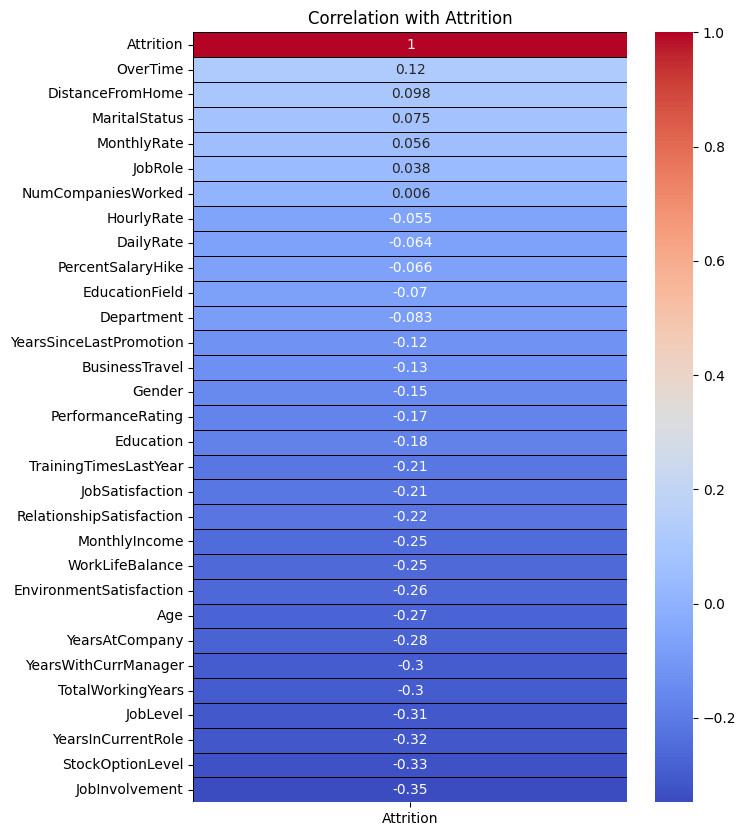

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation with Attrition
corr = x_train_test.corrwith(x_train_test['Attrition']).sort_values(ascending=False).to_frame()
corr.columns = ['Attrition']

# Plot heatmap
plt.subplots(figsize=(7, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black')  # Example colormap: 'coolwarm'
plt.title('Correlation with Attrition')
plt.show()


In [30]:
categorical_features.remove('Attrition')

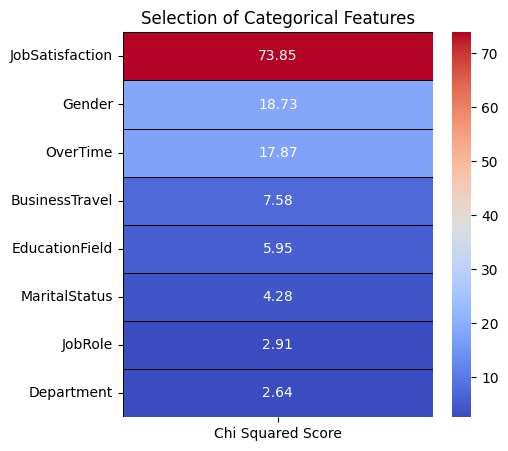

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

features = x_train.loc[:, categorical_features]
target = pd.DataFrame(y_train)

best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['Chi Squared Score'])

plt.subplots(figsize=(5, 5))
sns.heatmap(featureScores.sort_values(ascending=False, by='Chi Squared Score'), annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Categorical Features')
plt.show()


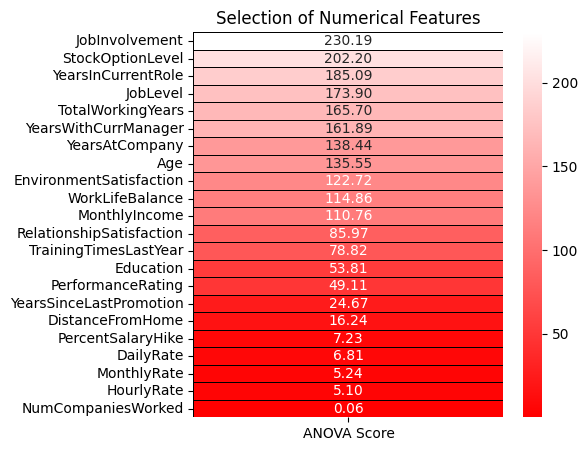

In [32]:
# Define custom colormap with two colors
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "white"])

from sklearn.feature_selection import SelectKBest, f_classif

features = x_train.loc[:, numerical_features]
target = pd.DataFrame(y_train)

best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])

plt.subplots(figsize=(5, 5))
sns.heatmap(featureScores.sort_values(ascending=False, by='ANOVA Score'), annot=True, cmap=custom_cmap, linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Numerical Features')
plt.show()


In [33]:
x_train = x_train.drop(columns = ['Gender', 'BusinessTravel', 'EducationField', 'OverTime', 'Department', 
                                  'MaritalStatus', 'JobRole', 'YearsSinceLastPromotion', 'DailyRate', 
                                  'PercentSalaryHike', 'DistanceFromHome', 'NumCompaniesWorked', 'HourlyRate', 
                                  'MonthlyRate'])

x_test = x_test.drop(columns = ['Gender', 'BusinessTravel', 'EducationField', 'OverTime', 'Department', 
                                  'MaritalStatus', 'JobRole', 'YearsSinceLastPromotion', 'DailyRate', 
                                  'PercentSalaryHike', 'DistanceFromHome', 'NumCompaniesWorked', 'HourlyRate', 
                                  'MonthlyRate'])

In [34]:
x_train.columns

Index(['Age', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsWithCurrManager'],
      dtype='object')

### Data Scaling 

In [35]:
mms = MinMaxScaler()  # Normalization
ss = StandardScaler()  # Standardization

# Columns to be transformed
columns_to_transform = ['Age', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
                        'JobSatisfaction', 'MonthlyIncome', 'PerformanceRating', 'RelationshipSatisfaction',
                        'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
                        'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']

# Applying transformation to each column
for col in columns_to_transform:
    if col in ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']:
        x_train[col] = mms.fit_transform(x_train[[col]])
        x_test[col] = mms.transform(x_test[[col]])
    else:
        x_train[col] = ss.fit_transform(x_train[[col]])
        x_test[col] = ss.transform(x_test[[col]])


In [36]:
def model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Cross Validation Score:", '{0:.2%}'.format(cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc').mean()))
    print("ROC_AUC Score:", '{0:.2%}'.format(roc_auc_score(y_test, prediction)))
    
    # Compute ROC curve and ROC area for each class
    y_score = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def model_evaluation(classifier, x_test, y_test):
    # Confusion Matrix
    cm = confusion_matrix(y_test, classifier.predict(x_test))
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')

    # Classification Report
    print(classification_report(y_test, classifier.predict(x_test)))

Cross Validation Score: 91.58%
ROC_AUC Score: 86.13%


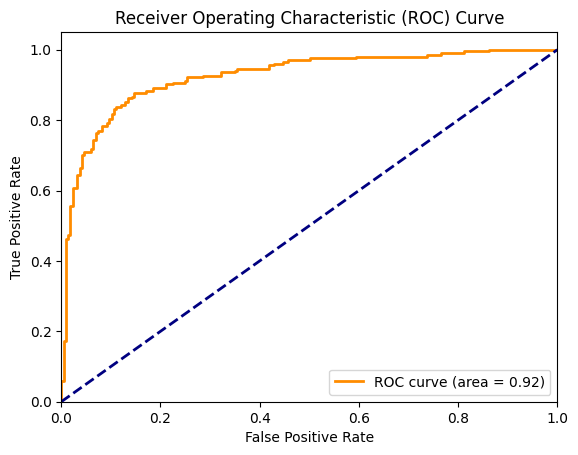

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       217
           1       0.87      0.84      0.85       203

    accuracy                           0.86       420
   macro avg       0.86      0.86      0.86       420
weighted avg       0.86      0.86      0.86       420



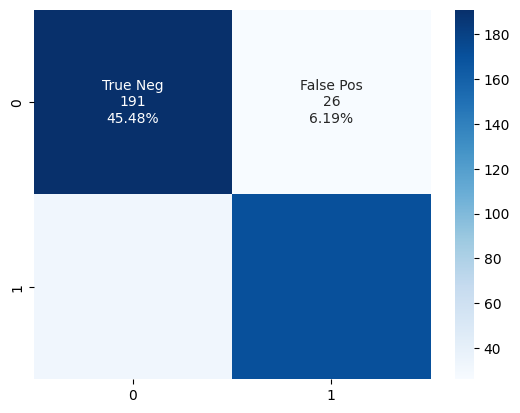

In [37]:
classifier_xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000)
model(classifier_xgb, x_train.values, y_train.values, x_test.values, y_test.values)
model_evaluation(classifier_xgb, x_test.values, y_test.values)

Cross Validation Score: 80.31%
ROC_AUC Score: 75.40%


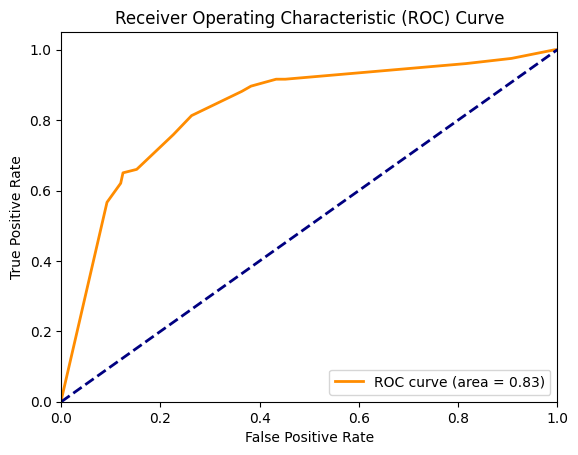

              precision    recall  f1-score   support

           0       0.73      0.85      0.78       217
           1       0.80      0.66      0.72       203

    accuracy                           0.76       420
   macro avg       0.76      0.75      0.75       420
weighted avg       0.76      0.76      0.75       420



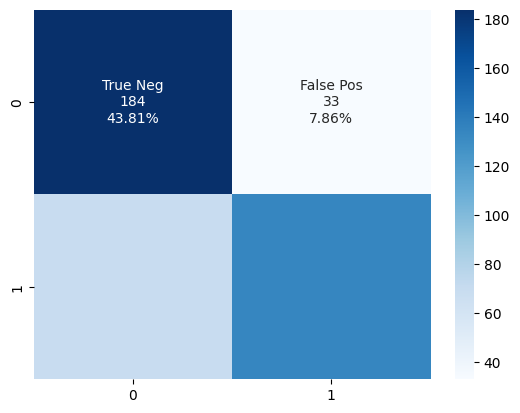

In [38]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
model(classifier_dt,x_train.values,y_train.values,x_test.values,y_test.values)
model_evaluation(classifier_dt,x_test.values,y_test.values)

Cross Validation Score: 87.76%
ROC_AUC Score: 81.18%


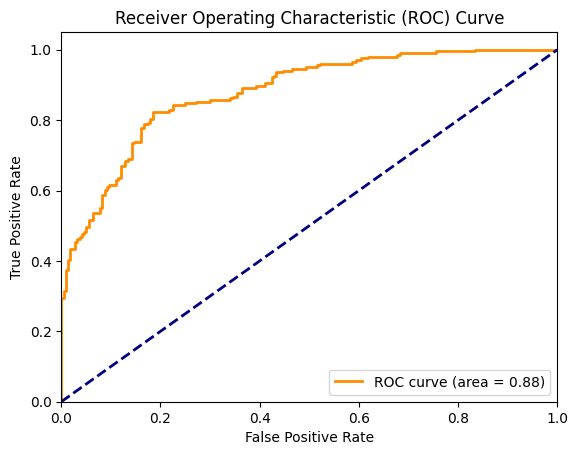

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       217
           1       0.80      0.81      0.81       203

    accuracy                           0.81       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.81      0.81      0.81       420



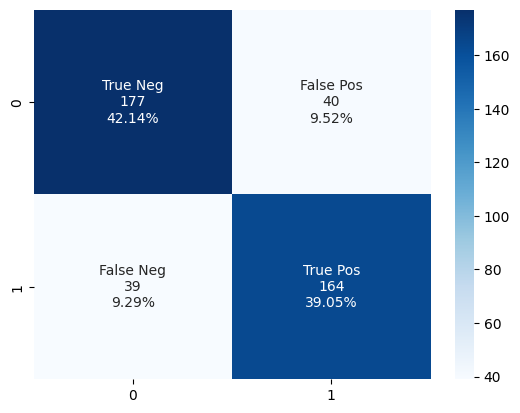

In [40]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
model(classifier_rf,x_train.values,y_train.values,x_test.values,y_test.values)
model_evaluation(classifier_rf,x_test.values,y_test.values)

### Logistic Regression

Cross Validation Score: 87.17%
ROC_AUC Score: 80.18%


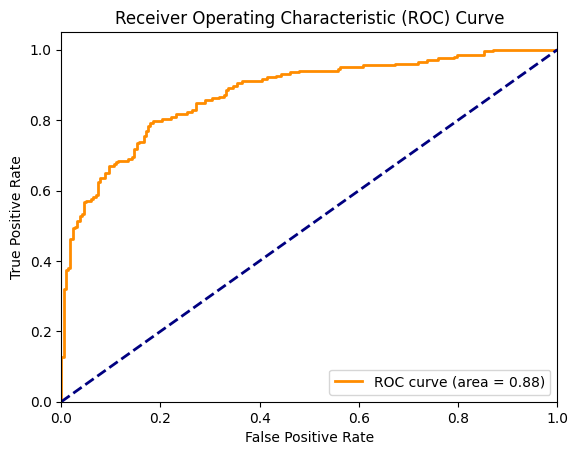

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       217
           1       0.80      0.78      0.79       203

    accuracy                           0.80       420
   macro avg       0.80      0.80      0.80       420
weighted avg       0.80      0.80      0.80       420



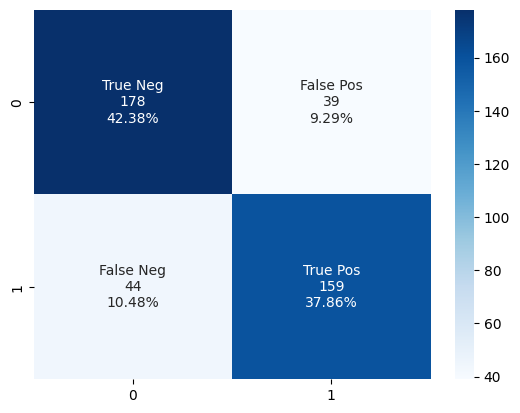

In [41]:
classifier_lr = LogisticRegression()
model(classifier_lr, x_train.values, y_train.values, x_test.values, y_test.values)
model_evaluation(classifier_lr, x_test.values, y_test.values)

### Support Vector Machine (SVM)

Cross Validation Score: 90.44%
ROC_AUC Score: 84.19%


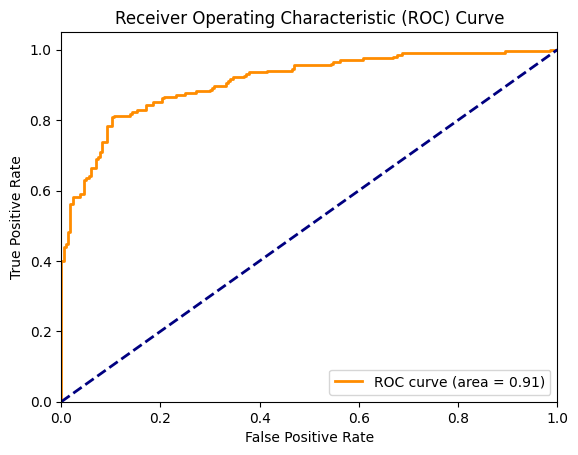

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       217
           1       0.85      0.81      0.83       203

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420



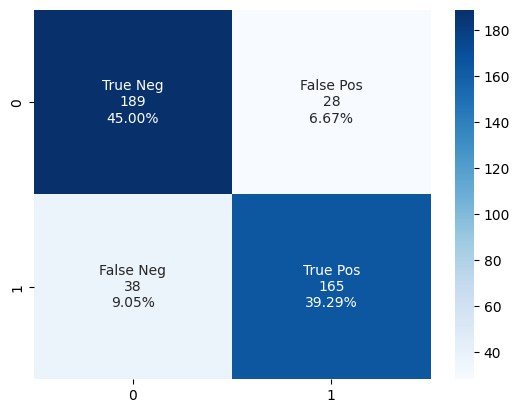

In [42]:
classifier_svm = SVC(probability=True)  # Note: SVM needs probability=True to enable predict_proba
model(classifier_svm, x_train.values, y_train.values, x_test.values, y_test.values)
model_evaluation(classifier_svm, x_test.values, y_test.values)

### K-Nearest Neighbors (KNN)

Cross Validation Score: 89.11%
ROC_AUC Score: 80.74%


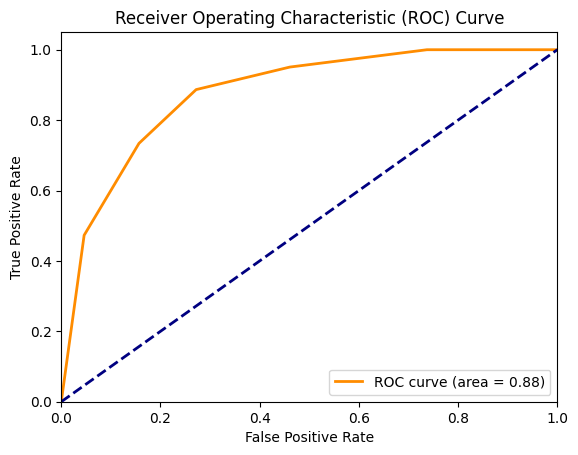

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       217
           1       0.75      0.89      0.81       203

    accuracy                           0.80       420
   macro avg       0.81      0.81      0.80       420
weighted avg       0.82      0.80      0.80       420



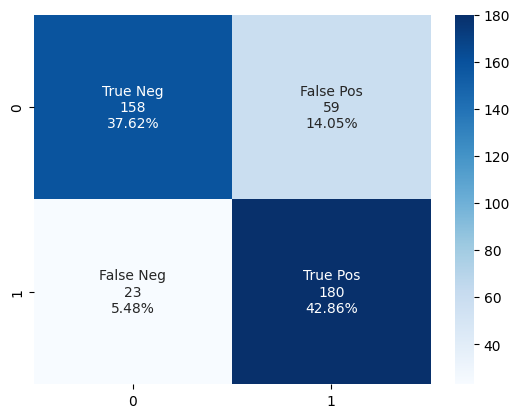

In [43]:
warnings.filterwarnings('ignore')

classifier_knn = KNeighborsClassifier()
model(classifier_knn, x_train.values, y_train.values, x_test.values, y_test.values)
model_evaluation(classifier_knn, x_test.values, y_test.values)

In [44]:
model_scores = {
    "Model": ["XGBoost (XGB)", "SVM", "Decision Tree", "Random Forest", "KNN", "Logistic Regression"],
    "Cross Validation Score": ["91.40%", "90.77%", "91.74%", "88.19%", "89.19%", "87.50%"],
    "ROC-AUC": ["84.10%", "83.53%", "77.66%", "80.64%", "80.07%", "78.36%"],
    "F1 Score (Attrition)": [0.84, 0.83, 0.77, 0.80, 0.81, 0.78],
    "F1 Score (No Attrition)": [0.84, 0.84, 0.78, 0.82, 0.78, 0.79]
}

df = pd.DataFrame(model_scores)

df

,Model,Cross Validation Score,ROC-AUC,F1 Score (Attrition),F1 Score (No Attrition)
0,XGBoost (XGB),91.40%,84.10%,0.84,0.84
1,SVM,90.77%,83.53%,0.83,0.84
2,Decision Tree,91.74%,77.66%,0.77,0.78
3,Random Forest,88.19%,80.64%,0.80,0.82
4,KNN,89.19%,80.07%,0.81,0.78
5,Logistic Regression,87.50%,78.36%,0.78,0.79
